/tmp/ipykernel_598434/883555187.py:44: RuntimeWarning: invalid value encountered in sqrt
  f = (1 - epsilon_limb + epsilon_limb*np.sqrt(1-r**2))*f


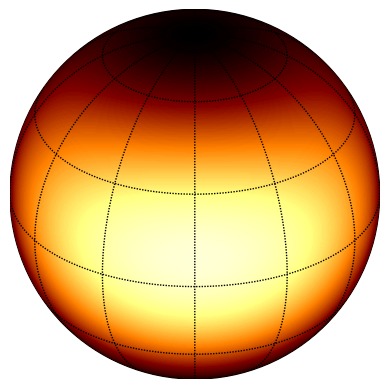

In [1]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
# set up orthographic map projection with
# perspective of satellite looking down at 50N, 100W.
# use low resolution coastlines.
#inc = 45
inc = 30
map = Basemap(projection='ortho',lat_0=inc,lon_0=0,resolution='l')

# draw lat/lon grid lines every 30 degrees.
#map.drawmeridians(np.arange(0,360,30))
#map.drawparallels(np.arange(-90,90,30))
map.drawmeridians(np.arange(0,360,30))
map.drawparallels(np.arange(-90,90,30))

# make up some data on a regular lat/lon grid.
nlats = 73; nlons = 145; delta = 2.*np.pi/(nlons-1)

lats = (0.5*np.pi-delta*np.indices((nlats,nlons))[0,:,:])
lons = (delta*np.indices((nlats,nlons))[1,:,:])

v_rot = 25 * np.cos(lats) * np.sin(np.deg2rad(90-inc)) * np.sin(lons)

v_rot *= (1-0.2*np.sin(lats)**2)

epsilon_lat = 1
f = (1-epsilon_lat*np.sin(lats)**2)

#mask = (np.abs(lats) < np.deg2rad(20)) & (np.abs(lons) < np.deg2rad(20))
#mask = (lats > np.deg2rad(30)) & (lats < np.deg2rad(60)) & (np.abs(lons) < np.deg2rad(50))
#f[mask] = 1.2

# compute native map projection coordinates of lat/lon grid.
x, y = map(lons*180./np.pi, lats*180./np.pi)

x_mean = (x[np.isfinite(x)].max() - x[np.isfinite(x)].min())/2 + x[np.isfinite(x)].min()
y_mean = (y[np.isfinite(y)].max() - y[np.isfinite(y)].min())/2 + y[np.isfinite(y)].min()
r = np.sqrt((x-x_mean)**2+(y-y_mean)**2)
r /= np.max(r[np.isfinite(r)])

epsilon_limb = 0.6
epsilon_limb = 0.9
f = (1 - epsilon_limb + epsilon_limb*np.sqrt(1-r**2))*f

# contour data over the map.
#cs = map.contourf(x,y,v_rot,200,cmap='bwr',vmin=-25,vmax=25)
cs = map.contourf(x,y,f,200,cmap='afmhot',vmin=0,vmax=1)
plt.show()

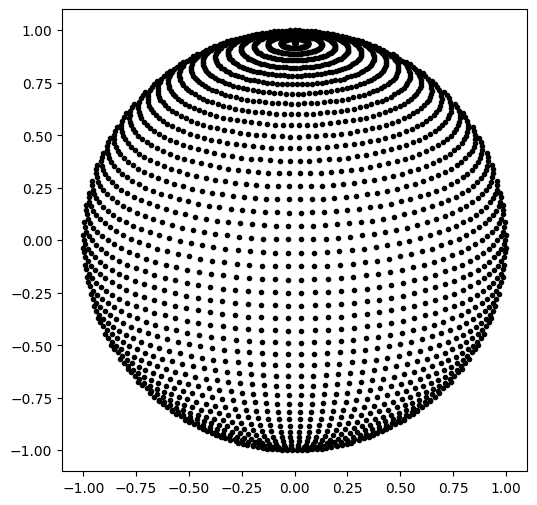

In [2]:
R = 1
inc = np.deg2rad(20)
lat_0 = inc
lon_0 = np.deg2rad(180)

lat = np.deg2rad(np.linspace(-90,90,10*5))[:,None]
lon = np.deg2rad(np.linspace(0,360,20*5))[None,:]

x = R * np.cos(lat) * np.sin(lon-lon_0)
y = R * (np.cos(lat_0)*np.sin(lat) - np.sin(lat_0)*np.cos(lat)*np.cos(lon-lon_0))

cos_c = np.sin(lat_0)*np.sin(lat) + np.cos(lat_0)*np.cos(lat)*np.cos(lon-lon_0)
mask = (cos_c > 0)

plt.figure(figsize=(6,6))
#plt.plot(x.flatten(), y.flatten(), 'C0.')
plt.plot(x[mask].flatten(), y[mask].flatten(), 'k.')
plt.xlim(-1.1,1.1); plt.ylim(-1.1,1.1)
plt.show()

In [3]:
import numpy as np
import pymultinest

import matplotlib as mpl
import matplotlib.pyplot as plt
#%matplotlib inline

import json

import retrieval_base.auxiliary_functions as af

def read_results(prefix, n_params, w_set='K2166'):

    # Set-up analyzer object
    analyzer = pymultinest.Analyzer(
        n_params=n_params, 
        outputfiles_basename=prefix
        )
    stats = analyzer.get_stats()

    # Load the equally-weighted posterior distribution
    posterior = analyzer.get_equal_weighted_posterior()
    posterior = posterior[:,:-1]

    # Read the parameters of the best-fitting model
    bestfit = np.array(stats['modes'][0]['maximum a posterior'])

    PT = af.pickle_load(prefix+'data/bestfit_PT.pkl')
    Chem = af.pickle_load(prefix+'data/bestfit_Chem.pkl')

    m_spec = af.pickle_load(prefix+f'data/bestfit_m_spec_{w_set}.pkl')
    d_spec = af.pickle_load(prefix+f'data/d_spec_{w_set}.pkl')

    LogLike = af.pickle_load(prefix+f'data/bestfit_LogLike_{w_set}.pkl')

    try:
        Cov = af.pickle_load(prefix+f'data/bestfit_Cov_{w_set}.pkl')
    except:
        Cov = None

    int_contr_em           = np.load(prefix+f'data/bestfit_int_contr_em_{w_set}.npy')
    int_contr_em_per_order = np.load(prefix+f'data/bestfit_int_contr_em_per_order_{w_set}.npy')
    int_opa_cloud          = np.load(prefix+f'data/bestfit_int_opa_cloud_{w_set}.npy')

    f = open(prefix+'data/bestfit.json')
    bestfit_params = json.load(f)
    f.close()

    print(posterior.shape)
    return posterior, bestfit, PT, Chem, int_contr_em, int_contr_em_per_order, int_opa_cloud, m_spec, d_spec, LogLike, Cov, bestfit_params

In [4]:
#prefix = './retrieval_outputs/fiducial_J_B_ret_8/test_'
#w_set = 'J1226'
#n_params = 29
prefix = './retrieval_outputs/fiducial_K_B_ret_19/test_'
w_set = 'K2166'
n_params = 28

res = read_results(prefix=prefix, n_params=n_params, w_set=w_set)
posterior, bestfit, PT, Chem, _, _, _, m_spec, d_spec, LogLike, Cov, bestfit_params = res
del res

  analysing data from ./retrieval_outputs/fiducial_K_B_ret_19/test_.txt
(2074, 28)


In [5]:
from scipy.interpolate import interp1d
import petitRADTRANS.nat_cst as nc

def rot_broadening_integration(
        vsini, 
        epsilon_limb=0, 
        epsilon_lat=0, 
        dif_rot_delta=0, 
        dif_rot_phi=1, 
        epsilon_band=0, 
        lat_band=None, 
        sigma_band=0, 
        inclination=26, 
        nr=10, ntheta=100, 
        wave=None, flux=None, 
        ):
    
    # Adopted from Carvalho & Johns-Krull (2023)

    flux_rot_broad = np.zeros_like(flux)
    disk_area_tot = 0.0

    all_r     = []
    all_theta = []
    all_v     = []
    all_f     = []
    all_lat   = []

    # Latitude at center of orthographic projection
    lat_0 = np.deg2rad(inclination)
    lon_0 = np.deg2rad(0)

    dr = 1/nr # Radial grid spacing
    # Loop over radial grid
    r_range = np.arange(dr/2, 1, dr)
    for r_i in r_range:

        ntheta_r_i = int(ntheta*r_i)        

        # Projected area
        area_ij = ((r_i + dr/2)**2 - (r_i - dr/2)**2) / ntheta_r_i
        
        # Loop over angle
        for j in range(ntheta_r_i):
            th_j = (np.pi + j*2*np.pi) / ntheta_r_i

            # Velocity of grid-point
            vl_ij = vsini * r_i * np.sin(th_j)

            # Scale by the inclination, turns vsini into v_eq
            #vl_ij *= np.abs(np.sin(np.deg2rad(90-inclination)))

            # Orthographic projection
            c = np.arcsin(r_i) # Angular distance
            x = r_i * np.sin(th_j)
            y = r_i * np.cos(th_j)

            # Lat-/long-itude of grid-point, based on inclination
            lat_ij = np.arcsin(
                np.cos(c)*np.sin(lat_0) + y/r_i*np.sin(c)*np.cos(lat_0)
            )
            lon_ij = lon_0 + np.arctan2(
                x*np.sin(c), r_i*np.cos(c)*np.cos(lat_0) - y*np.sin(c)*np.sin(lat_0)
            )

            all_lat.append(lat_ij)
            
            if dif_rot_delta != 0:
                # Apply differential rotation
                vl_ij *= (
                    1 - dif_rot_delta * np.sin(dif_rot_phi*lat_ij)**2
                    )
                
            # Factor to keep track of (limb)-darkening
            f_ij = 1
            if epsilon_limb != 0:
                # Apply linear limb-darkening
                f_ij *= (1 - epsilon_limb + epsilon_limb*np.sqrt(1-r_i**2))
            if epsilon_lat != 0:
                # Apply latitude-darkening
                f_ij *= (
                    1 - epsilon_lat * np.sin(dif_rot_phi*lat_ij)**2
                    )

            if (lat_band is not None) and (sigma_band != 0) and (epsilon_band != 0):
                # Add a band, symmetric across the equator
                f_ij *= (
                    1 - epsilon_band * np.exp(-(np.rad2deg(lat_ij)-lat_band)**2/(2*sigma_band**2))
                    )
                f_ij *= (
                    1 - epsilon_band * np.exp(-(np.rad2deg(lat_ij)-(-lat_band))**2/(2*sigma_band**2))
                    )
            
            # Apply Doppler shift
            wave_shifted_ij = wave * (1 + vl_ij/(nc.c*1e-5))
            flux_shifted_ij = np.interp(wave_shifted_ij, wave, flux, left=np.nan, right=np.nan)

            # Add to the global spectrum
            flux_rot_broad += f_ij * area_ij * flux_shifted_ij
            disk_area_tot  += f_ij * area_ij

            all_r.append(r_i)
            all_theta.append(th_j)
            all_v.append(vl_ij)
            all_f.append(f_ij)

    # Normalize to account for over/under-estimation of disk area
    flux_rot_broad /= disk_area_tot

    #print(np.max(np.rad2deg(all_lat)), np.min(np.rad2deg(all_lat)))
    return wave, flux_rot_broad, np.array(all_r), np.array(all_theta), np.array(all_v), np.array(all_f)

from astropy.modeling.models import Lorentz1D
wave = np.linspace(2170.0,2230.0,10001)
fwhm = 0.05 #0.01

flux_init = np.ones_like(wave)
flux_init -= Lorentz1D(amplitude=0.5, x_0=2200, fwhm=fwhm)(wave)

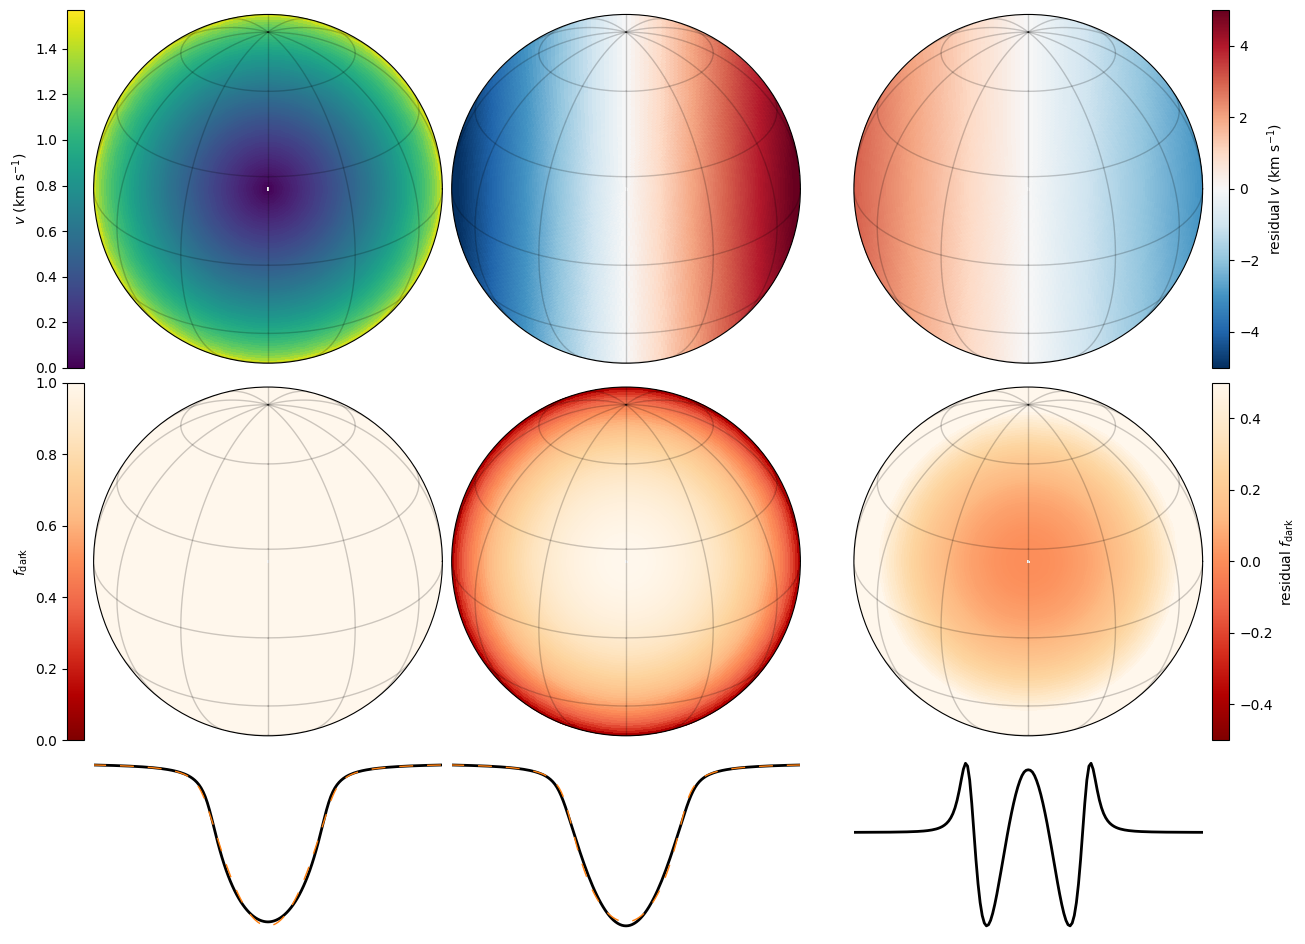

In [11]:
#nr, ntheta = 10, 100
nr, ntheta = 70, 250
#nr, ntheta = 250, 1000

_, flux_local, _, _, all_v_local, all_f_local = rot_broadening_integration(
    vsini=1, epsilon_limb=0, epsilon_lat=0, dif_rot_delta=0, dif_rot_phi=1, 
    nr=nr, ntheta=ntheta, wave=wave, flux=flux_init, 
    )

_, flux_ref, _, _, all_v_ref, all_f_ref = rot_broadening_integration(
    #vsini=25, epsilon_limb=0.5, epsilon_lat=0, dif_rot_delta=0, dif_rot_phi=1, 
    vsini=25.9, epsilon_limb=1.0, epsilon_lat=0, dif_rot_delta=0, dif_rot_phi=1, 
    nr=nr, ntheta=ntheta, wave=wave, flux=flux_init, 
    )

wave, flux_mod, all_r, all_theta, all_v_mod, all_f_mod = rot_broadening_integration(
    vsini=25.9-3, epsilon_limb=0.0, epsilon_lat=0, dif_rot_delta=0, dif_rot_phi=1, 
    #vsini=25, epsilon_limb=0.65, epsilon_lat=0.5, dif_rot_delta=0, dif_rot_phi=1, 
    #vsini=25, epsilon_limb=0.65, epsilon_lat=0.5, dif_rot_delta=0, dif_rot_phi=8, 
    #vsini=24.7, epsilon_limb=0.76, epsilon_lat=0.87, dif_rot_delta=0, dif_rot_phi=2.9, 
    #vsini=25.5, epsilon_limb=0.2, epsilon_lat=0.0, dif_rot_delta=0.23, dif_rot_phi=1.5,
    #vsini=25.6, epsilon_limb=0.35, epsilon_lat=0.14, dif_rot_delta=0.23, dif_rot_phi=1.41,  
    #vsini=25.8, epsilon_limb=0.63, epsilon_lat=0.17, dif_rot_delta=0.25, dif_rot_phi=1.0,  
    #vsini=26.0, epsilon_limb=0.25, epsilon_band=0.59, lat_band=19, sigma_band=42,  
    #vsini=26.0, epsilon_limb=0.25, epsilon_band=0.59, lat_band=40, sigma_band=15,  
    nr=nr, ntheta=ntheta, wave=wave, flux=flux_init, 
    )

def orthographic_to_xy(lat, lon, lat_0, lon_0, R=1):

    x = R * np.cos(lat) * np.sin(lon-lon_0)
    y = R * (np.cos(lat_0)*np.sin(lat) - np.sin(lat_0)*np.cos(lat)*np.cos(lon-lon_0))

    c = np.arccos(
        np.sin(lat_0)*np.sin(lat) + np.cos(lat_0)*np.cos(lat)*np.cos(lon-lon_0)
    )

    mask = (c > -np.pi/2) & (c < np.pi/2)
    x[~mask] = np.nan
    y[~mask] = np.nan
    return x, y, c

def plot_grid(ax, lat_grid=np.arange(-90,90+1e-6,30), lon_grid=np.arange(0,360,30), inclination=26, **kwargs):

    lat = np.deg2rad(np.linspace(-90,90,100))
    lon = np.deg2rad(np.linspace(0,360,100))

    for lat_i in np.deg2rad(lat_grid):

        # Orthographic projection
        x, y, c = orthographic_to_xy(lat_i, lon, np.deg2rad(inclination), np.deg2rad(0))

        # Convert to polar coordinates
        r = np.sqrt(x**2 + y**2)
        phi = np.arctan2(y,x)

        ax.plot(phi, r, **kwargs)

    for lon_i in np.deg2rad(lon_grid):
        
        # Orthographic projection
        x, y, c = orthographic_to_xy(lat, lon_i, np.deg2rad(inclination), np.deg2rad(0))

        # Convert to polar coordinates
        r = np.sqrt(x**2 + y**2)
        phi = np.arctan2(y,x)

        ax.plot(phi, r, **kwargs)

def plot_map(ax, x, y, z, cax=None, **kwargs):

    dy = np.diff(np.unique(y)[[0,1]])[0]

    for y_i in np.unique(y):
        x_i = x[y==y_i]
        z_i = z[y==y_i]
        y_i = np.array([y_i])

        xx, yy = np.meshgrid(x_i, y_i)
        zz = z_i.reshape(xx.shape)

        # Extend the grid to form the corners of mesh
        yy -= y.min()
        yy = np.concatenate((yy, yy.min()+2*dy*np.ones((1,yy.shape[1]))), axis=0)
        yy = np.concatenate((yy, yy[:,-1][:,None]), axis=1)

        xx -= xx.min()
        xx = np.concatenate((xx, 2*np.pi*np.ones((xx.shape[0],1))), axis=1)
        xx = np.concatenate((xx, xx[-1,:][None,:]), axis=0)
        xx += np.pi/2

        cntr = ax.pcolormesh(xx, yy, zz, shading='auto', **kwargs)    

    if cax is not None:
        import matplotlib as mpl
        norm = mpl.colors.Normalize(vmin=kwargs.get('vmin'), vmax=kwargs.get('vmax'))
        plt.colorbar(
            mpl.cm.ScalarMappable(norm=norm, cmap=kwargs.get('cmap')), ax=ax, cax=cax
            )

    return cntr

fig = plt.figure(figsize=(15,12))
gs = fig.add_gridspec(
    nrows=3, ncols=6, #left=0.15, right=0.89, top=0.98, bottom=0.08, 
    width_ratios=[0.05,1,1,0.1,1,0.05], height_ratios=[1,1,0.5], 
    hspace=0.05, wspace=0.05,
    )

cax = np.array([
    [fig.add_subplot(gs[0,0]), fig.add_subplot(gs[0,-1])], 
    [fig.add_subplot(gs[1,0]), fig.add_subplot(gs[1,-1])]
    ])

ax = np.array([
    [fig.add_subplot(gs[0,1],projection='polar'), fig.add_subplot(gs[0,2],projection='polar'), fig.add_subplot(gs[0,4],projection='polar')], 
    [fig.add_subplot(gs[1,1],projection='polar'), fig.add_subplot(gs[1,2],projection='polar'), fig.add_subplot(gs[1,4],projection='polar')], 
    [fig.add_subplot(gs[2,1]), fig.add_subplot(gs[2,2]), fig.add_subplot(gs[2,4])], 
    ])

for i, ax_i in enumerate(ax[:2,:].flatten()):
    ax_i.grid(False)
    ax_i.set_xticks([])
    ax_i.set_yticks([])
    #ax_i.set_ylim(all_r.min(),all_r.max())
    ax_i.set_ylim(0,1)

    plot_grid(ax_i, c='k', alpha=0.2, lw=1)

plot_map(
    ax[0,0], all_theta, all_r, np.arcsin(all_r/1), cmap='viridis', vmin=0, vmax=np.pi/2, cax=cax[0,0]
)
#plot_map(
#    ax[0,0], all_theta, all_r, all_theta, cmap='viridis', vmin=-2*np.pi, vmax=2*np.pi, cax=cax[0,0]
#    )
#plot_map(
#    ax[0,0], all_theta, all_r, -all_v_mod, cmap='RdBu_r', vmin=-25, vmax=25, cax=cax[0,0]
#    )
plot_map(
    ax[0,1], all_theta, all_r, -all_v_ref, cmap='RdBu_r', vmin=-25, vmax=25
    )
plot_map(
    ax[0,2], all_theta, all_r, -(all_v_mod-all_v_ref), cmap='RdBu_r', vmin=-5, vmax=5, cax=cax[0,1]
    )

vmax = max([1, all_f_mod.max(), all_f_ref.max()])
plot_map(
    ax[1,0], all_theta, all_r, all_f_mod, cmap='OrRd_r', vmin=0, vmax=vmax, cax=cax[1,0], 
    )
plot_map(
    ax[1,1], all_theta, all_r, all_f_ref, cmap='OrRd_r', vmin=0, vmax=vmax, 
    )
plot_map(
    ax[1,2], all_theta, all_r, all_f_mod-all_f_ref, cmap='OrRd_r', vmin=-0.5, vmax=+0.5, cax=cax[1,1], 
    )

ax[2,0].plot(wave, flux_mod, c='k', lw=2)
ax[2,0].plot(wave, flux_ref, c='C1', lw=1, ls=(0,(10,10)))
ax[2,1].plot(wave, flux_ref, c='k', lw=2)
ax[2,1].plot(wave, flux_mod, c='C1', lw=1, ls=(0,(10,10)))
ax[2,2].plot(wave, flux_mod-flux_ref, c='k', lw=2)

for cax_i in cax[:,0].flatten():
    cax_i.yaxis.tick_left()
    cax_i.yaxis.set_label_position('left')
cax[0,0].set(ylabel=r'$v\ \mathrm{(km\ s^{-1})}$')
cax[0,1].set(ylabel=r'residual $v\ \mathrm{(km\ s^{-1})}$')

cax[1,0].set(ylabel=r'$f_\mathrm{dark}$')
cax[1,1].set(ylabel=r'residual $f_\mathrm{dark}$')

for i, ax_i in enumerate(ax[-1,:].flatten()):
    ax_i.axis('off')
    ax_i.set_xlim(2200-0.5,2200+0.5)

plt.show()

In [12]:
np.rad2deg(np.arcsin(all_r/1))

array([ 0.40925905,  1.22786069,  1.22786069, ..., 83.14776167,
       83.14776167, 83.14776167])

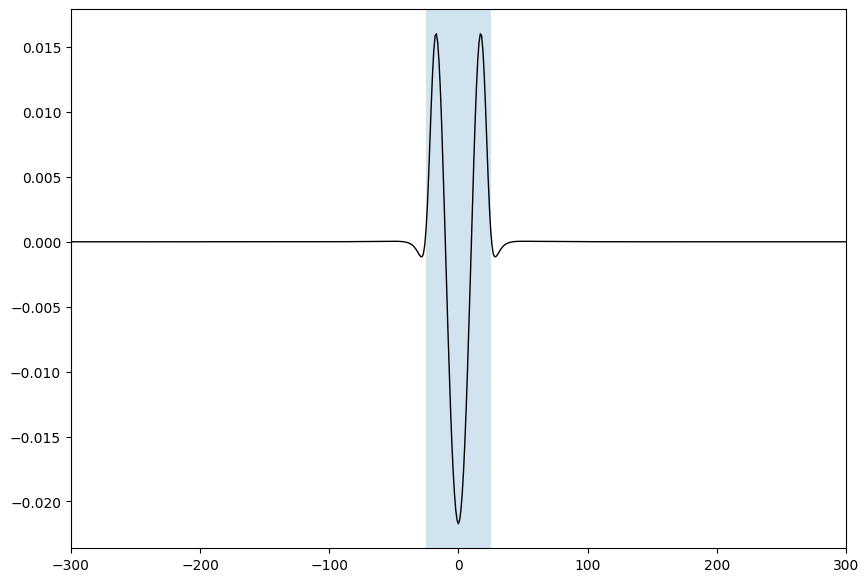

In [660]:
rv = np.arange(-300,300+1e-6,1)
CCF = np.ones_like(rv) * np.nan

for i, rv_i in enumerate(rv):

    wave_shifted = wave * (1+rv_i/3e5)
    #flux_shifted = np.interp(wave_shifted[200:-200], wave, flux)
    flux_shifted = np.interp(wave_shifted[200:-200], wave, flux_mod-flux_ref)

    #CCF[i] = np.nansum(flux_shifted * flux_ref[200:-200])
    CCF[i] = np.nansum(flux_shifted * flux_local[200:-200])

fig, ax = plt.subplots(figsize=(10,7))
ax.axvspan(xmin=-25, xmax=+25, fc='C0', ec='none', alpha=0.2)
ax.plot(rv, CCF, c='k', lw=1)
ax.set(xlim=(-300,300))
plt.show()